In [1]:
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

In [2]:

# # Установка остальных пакетов
# %pip install ultralytics
# %pip install opencv-python==4.8.0.74
# %pip install wandb

In [3]:
import os
import sys
from pathlib import Path
import yaml
import torch
from ultralytics import YOLO

In [4]:
# Проверка доступности CUDA
print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA версия: {torch.version.cuda}")
    print(f"Количество GPU: {torch.cuda.device_count()}")
    print(f"Текущее GPU: {torch.cuda.get_device_name(0)}")
    print(f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CUDA недоступна, будет использоваться CPU (тренировка будет медленнее)")

PyTorch версия: 2.10.0+cu130
CUDA доступна: True
CUDA версия: 13.0
Количество GPU: 1
Текущее GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Память GPU: 7.62 GB


In [5]:
# ---------------- БАЗОВАЯ НАСТРОЙКА ----------------
PROJECT_ROOT = Path("/home/gleb/Документы/33.VKR/mvp/road_monitoring").resolve()
os.chdir(PROJECT_ROOT)

os.environ['PYTHONIOENCODING'] = 'utf-8'
os.environ['LANG'] = 'ru_RU.UTF-8'
os.environ['LC_ALL'] = 'ru_RU.UTF-8'
if hasattr(sys.stdout, 'reconfigure'):
    sys.stdout.reconfigure(encoding='utf-8')
if hasattr(sys.stderr, 'reconfigure'):
    sys.stderr.reconfigure(encoding='utf-8')

print(f"Текущая директория: {os.getcwd()}")
print(f"Кодировка: {sys.stdout.encoding}")

model_type = "yolov9s.pt"
NAME_MODEL = "yolov9s_rdd_default_run"
DATASET_NAME = "RDD_SPLIT"

TRAINING_DIR = PROJECT_ROOT / "training"
CFG_PATH     = TRAINING_DIR / "args.yaml"
RUNS_SUBDIR = DATASET_NAME   # Поддиректория в runs для сохранения результатов (соответствует имени датасета)
DATA_PATH    = TRAINING_DIR / "datasets" / DATASET_NAME / "rdd_split.yaml"
TRAIN_MODEL  = TRAINING_DIR / "pretrained_models" / model_type


Текущая директория: /home/gleb/Документы/33.VKR/mvp/road_monitoring
Кодировка: UTF-8


In [6]:
# ---------------- ЧТЕНИЕ И МОДИФИКАЦИЯ YAML ----------------
with open(CFG_PATH, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

# переопределяем только то, что нужно
# cfg.update({
#     "model": str(TRAIN_MODEL),                      # yolov8s.pt
#     "data": str(DATA_PATH),
#     "epochs": 25,
#     "patience": 18,
#     "lr0": 0.0025,
#     "warmup_epochs": 2,
#     "cls": 0.8,
#     "scale": 0.25,
#     "device": 0 if torch.cuda.is_available() else "cpu",
#     "project": str(TRAINING_DIR / "runs" / RUNS_SUBDIR),
#     "name": NAME_MODEL,
# })

cfg.update({
    "batch": 24,
    "model": str(TRAIN_MODEL),          # yolov9s.pt
    "data": str(DATA_PATH),
    "device": 0 if torch.cuda.is_available() else "cpu",
    "project": str(TRAINING_DIR / "runs" / RUNS_SUBDIR),
    "name": NAME_MODEL,
})


print("\nИспользуемые ключевые параметры:")
for k in ["model", "data", "epochs", "lr0", "patience", "batch", "imgsz", "mosaic", "mixup", "copy_paste", "box", "cls", "dfl", "project", "name"]:
    print(f"{k}: {cfg[k]}")


Используемые ключевые параметры:
model: /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/pretrained_models/yolov9s.pt
data: /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/datasets/RDD_SPLIT/rdd_split.yaml
epochs: 100
lr0: 0.01
patience: 20
batch: 24
imgsz: 640
mosaic: 0.0
mixup: 0.0
copy_paste: 0.0
box: 7.5
cls: 0.5
dfl: 1.5
project: /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/runs/RDD_SPLIT
name: yolov9s_rdd_default_run


In [7]:
# ---------------- ЗАПУСК ОБУЧЕНИЯ ----------------
device = cfg["device"]
print(f"\nИспользуемое устройство: {device}")
print("Автовзвешивание классов: включено (YOLOv8)\n")

model = YOLO(cfg["model"])

results = model.train(**cfg)

print(f"\nТРЕНИРОВКА ЗАВЕРШЕНА!")
print(f"Результаты: {cfg['project']}/{cfg['name']}")


Используемое устройство: 0
Автовзвешивание классов: включено (YOLOv8)

New https://pypi.org/project/ultralytics/8.4.10 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.4.9 🚀 Python-3.12.3 torch-2.10.0+cu130 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7806MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=24, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/home/gleb/Документы/33.VKR/mvp/road_monitoring/training/datasets/RDD_SPLIT/rdd_split.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None

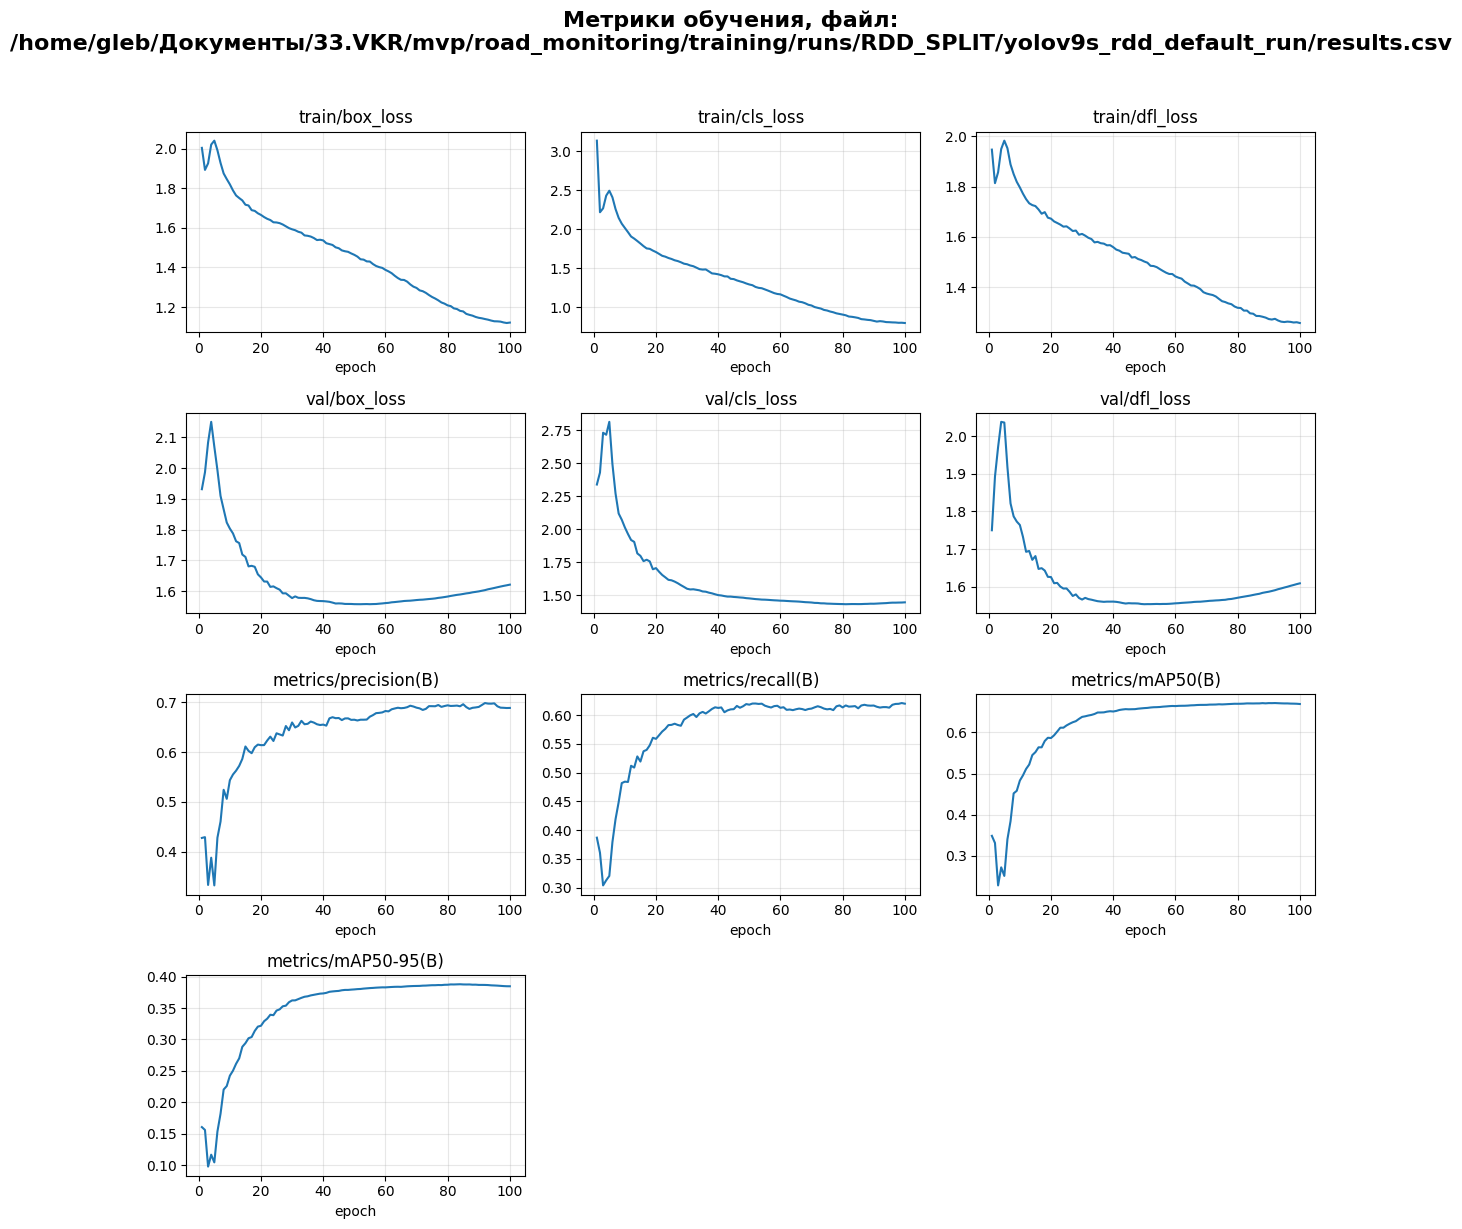

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

csv_path = TRAINING_DIR / "runs" / RUNS_SUBDIR / NAME_MODEL / "results.csv"
# путь к CSV

df = pd.read_csv(csv_path)

# какие колонки рисовать
cols = [
    "train/box_loss",
    "train/cls_loss",
    "train/dfl_loss",
    "val/box_loss",
    "val/cls_loss",
    "val/dfl_loss",
    "metrics/precision(B)",
    "metrics/recall(B)",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
]

fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.ravel()

fig.suptitle(f'Метрики обучения, файл:\n{csv_path}', fontsize=16, fontweight='bold', y=1.02)


for ax, col in zip(axes, cols):
    ax.plot(df["epoch"], df[col], label=col)
    ax.set_title(col, fontsize=12)
    ax.set_xlabel("epoch", fontsize=10)
    ax.grid(True, alpha=0.3)

# Скрываем лишние subplots (последние 2)
for ax in axes[len(cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
from ultralytics import YOLO
from pathlib import Path

# Используем переменные из Cell 4
model_path = TRAINING_DIR / "runs" / RUNS_SUBDIR / NAME_MODEL / "weights" / "best.pt"
data_path  = DATA_PATH

model = YOLO(str(model_path))

metrics = model.val(
    data=str(data_path),
    split="test",        # важное место
    imgsz=640,
    batch=24,
    device=0,
    save_json=True,
    project=str(TRAINING_DIR / "runs/test_eval"),
    name=f"{NAME_MODEL}_test",
)

print(f'mAP@0.5-0.95 {metrics.box.map}')       # mAP@0.5-0.95
print(f'mAP@0.5 {metrics.box.map50}')    # mAP@0.5
print(f'per-class AP {metrics.box.maps}')     # per-class AP

Ultralytics 8.4.9 🚀 Python-3.12.3 torch-2.10.0+cu130 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7806MiB)
YOLOv9s summary (fused): 197 layers, 7,168,636 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 55.6±35.6 MB/s, size: 58.5 KB)
val: Scanning /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/datasets/RDD_SPLIT/test/labels.cache... 5758 images, 1790 backgrounds, 531 corrupt: 100% ━━━━━━━━━━━━ 5758/5758 3.5Git/s 0.0s
val: /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/datasets/RDD_SPLIT/test/images/China_Drone_000286.jpg: ignoring corrupt image/label: Label class 4 exceeds dataset class count 4. Possible class labels are 0-3
val: /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/datasets/RDD_SPLIT/test/images/China_Drone_000383.jpg: ignoring corrupt image/label: Label class 4 exceeds dataset class count 4. Possible class labels are 0-3
val: /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/datasets/RDD_SPLIT/test/im